In [1]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gzip
import shutil
import glob
import rioxarray as rxr
from scipy import stats, interpolate
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
from scipy.stats import norm
from copulas.bivariate import Frank, Clayton, Gumbel
from copulas.multivariate import GaussianMultivariate, VineCopula
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, IndependenceCopula, GaussianCopula)
import seaborn as sns

In [2]:
# Set dataset dir

dataset = '../../datasets/'
et = os.path.join(dataset, 'et/gha_lsa_et.nc')
precipitation = os.path.join(dataset, 'precipitation_chirps/precip_chirps_gha.nc')
tws = os.path.join(dataset, 'gha_tws.nc')

In [3]:
os.listdir(dataset)

['precipitation_chirps',
 'ITSG_grace_data',
 'gha_tws.nc',
 'gha',
 '.ipynb_checkpoints',
 'gha.zip',
 'precipitation_chirps.zip',
 'et_stacked',
 'et',
 'final_data',
 'grace_fo']

In [4]:
# Open and display

et_data = xr.open_dataset(et)['ET']

precipitation_data = xr.open_dataset(precipitation)['precipitation']

tws_data = xr.open_dataset(tws)['twsddk']


In [5]:
et_data

<xarray.DataArray 'ET' (time: 252, lat: 697, lon: 592)>
[103981248 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 23.1 23.05 23.0 22.95 ... -11.55 -11.6 -11.65 -11.7
  * lon      (lon) float32 21.85 21.9 21.95 22.0 22.05 ... 51.25 51.3 51.35 51.4
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-12-01
Attributes:
    long_name:     ET
    units:         mm
    grid_mapping:  crs

In [170]:
sample = et_data.mean('time')[et_data>10]

IndexError: Boolean array size 252 is used to index array with shape (697,).

In [6]:
precipitation_data

<xarray.DataArray 'precipitation' (time: 250, y: 698, x: 591)>
[103129500 values with dtype=float32]
Coordinates:
    band     int64 ...
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * y        (y) float64 23.12 23.07 23.02 22.97 ... -11.58 -11.63 -11.68 -11.73
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_DATETIME:          2015:01:30 07:43:45
    TIFFTAG_DOCUMENTNAME:      /home/CHIRPS/monthly/v2.0/africa/chirps-v2.0.2...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.3, Exelis Visual Information Solutions, ...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    units:                     mm
    grid_mapping:              spatial_ref

In [7]:
tws_data

<xarray.DataArray 'twsddk' (lat: 34, lon: 30, time: 237)>
[241740 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
  * lat      (lat) float64 -11.0 -10.0 -9.0 -8.0 -7.0 ... 19.0 20.0 21.0 22.0
  * lon      (lon) float64 22.0 23.0 24.0 25.0 26.0 ... 47.0 48.0 49.0 50.0 51.0
Attributes:
    grid_mapping:  spatial_ref

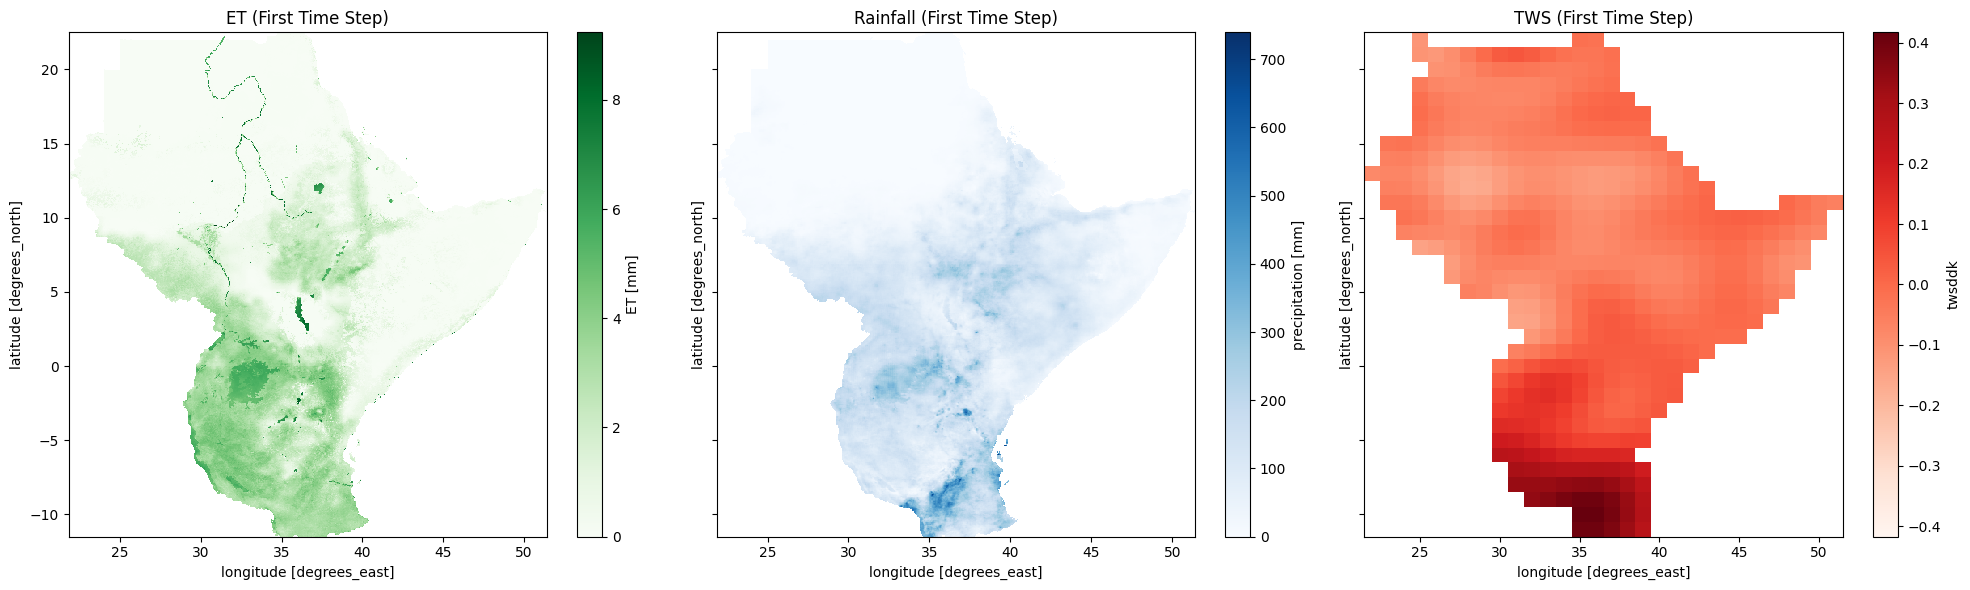

In [8]:
et1 = et_data.isel(time=0)
precip1 = precipitation_data.isel(time=0)
tws1 = tws_data.isel(time=0)

# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
et1.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
precip1.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
tws1.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

plt.tight_layout()
plt.show()

In [9]:
# Variables at a location in GHA

lat = 5.34
lon = 45.34

et_poi = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

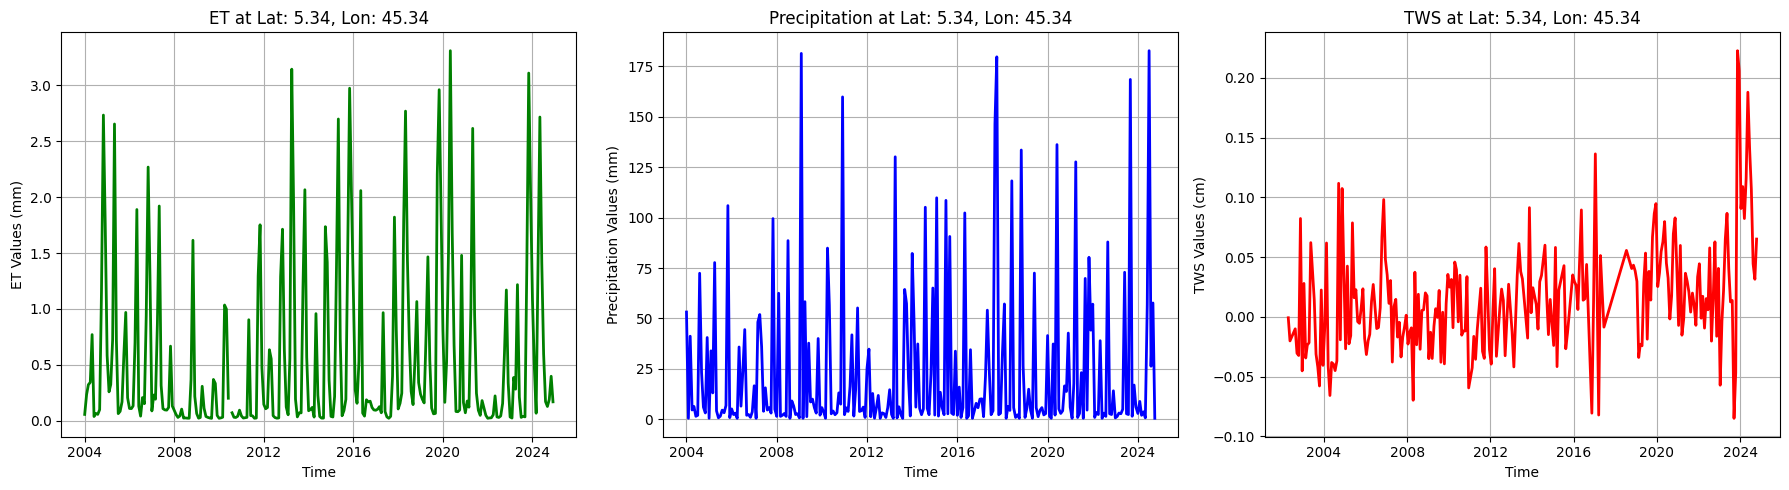

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

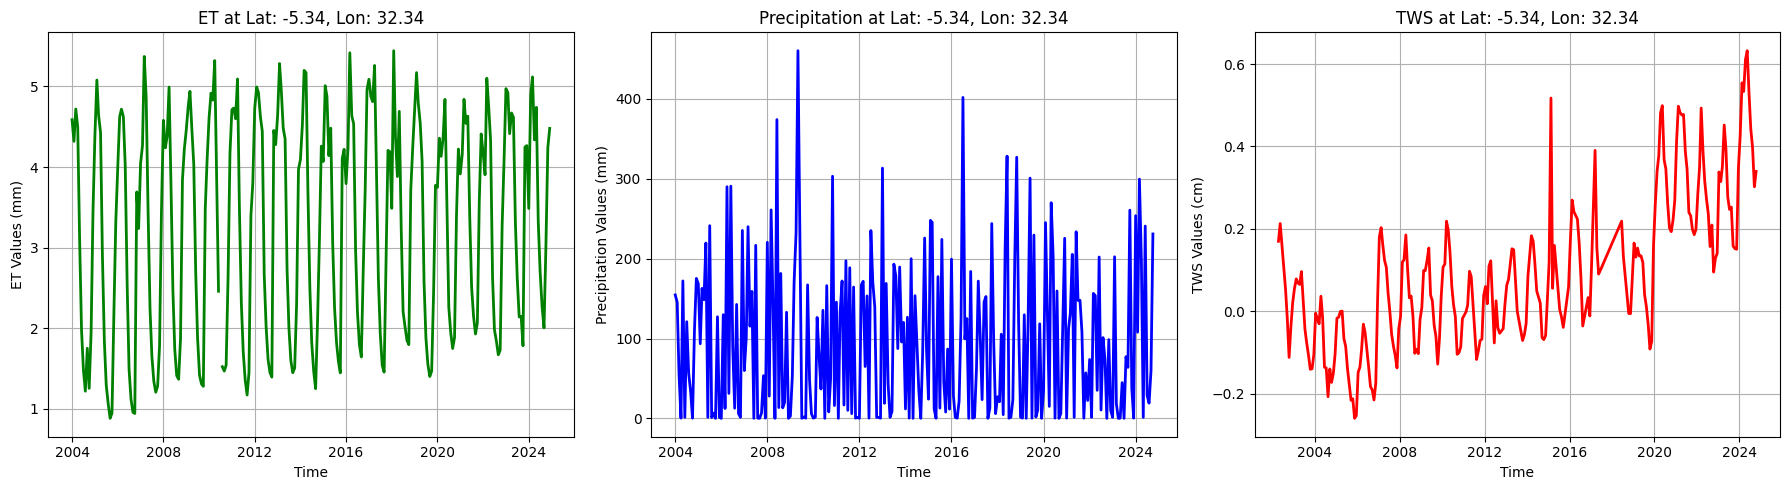

In [11]:
# Variables at a location in GHA

lat = -5.34
lon = 32.34

et_poi = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

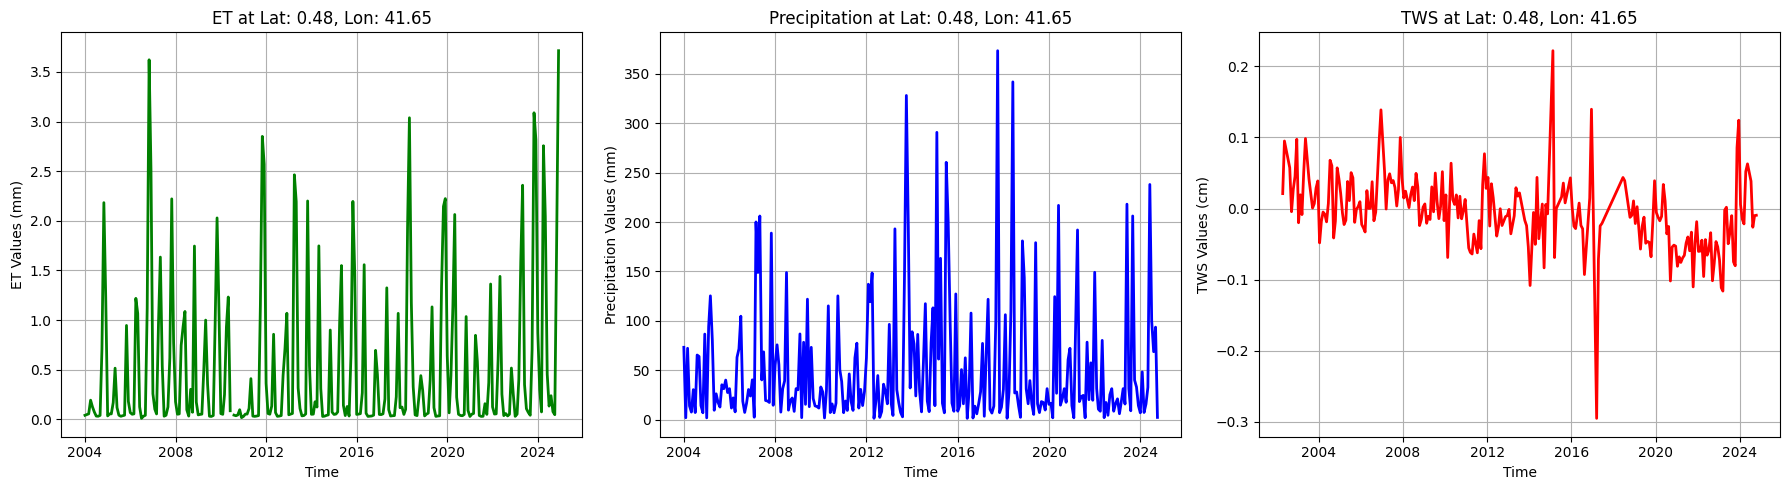

In [181]:
# Variables at a location in GHA

# Water body
lat = -1.15
lon = 32.87

lat = 3.81
lon = 36.04

# Land
# lat = 8.58
# lon = 31.56

lat = 0.48
lon = 41.65


et_poi_1 = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi_1 = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi_1 = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi_1.time, et_poi_1.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi_1.time, pre_poi_1.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi_1.time, tws_poi_1.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

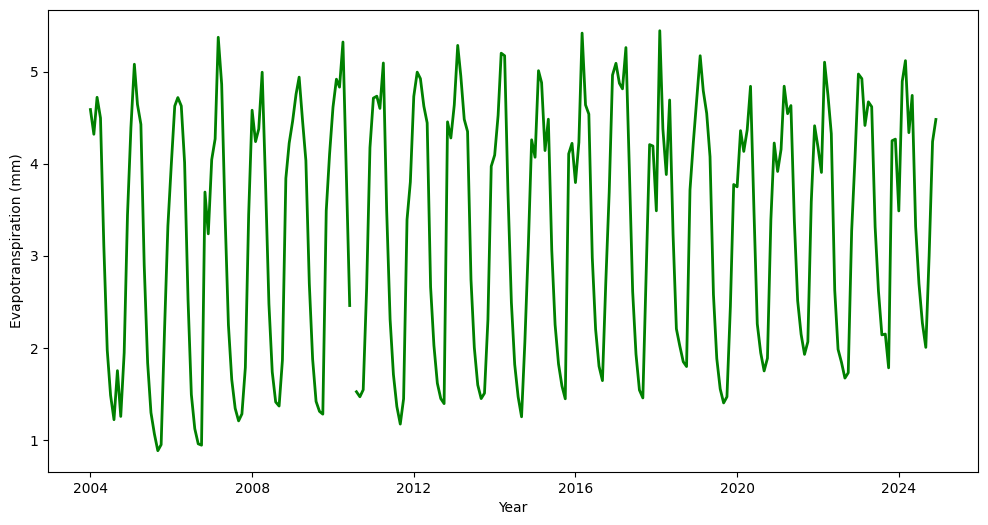

In [12]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(et_poi.time, et_poi.values, color='green', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Evapotranspiration (mm)")
# plt.title("Time Series Plot")
plt.show()

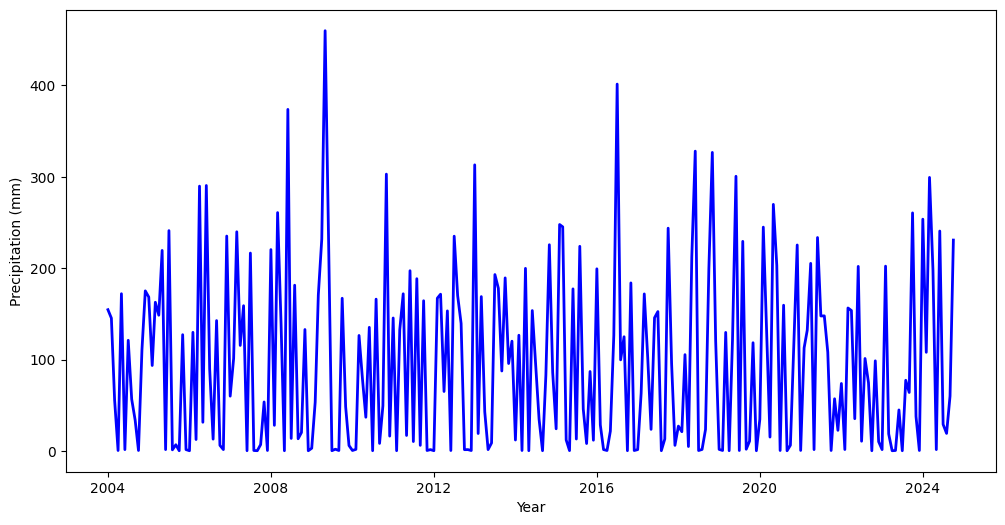

In [13]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
# plt.title("Time Series Plot")
plt.show()


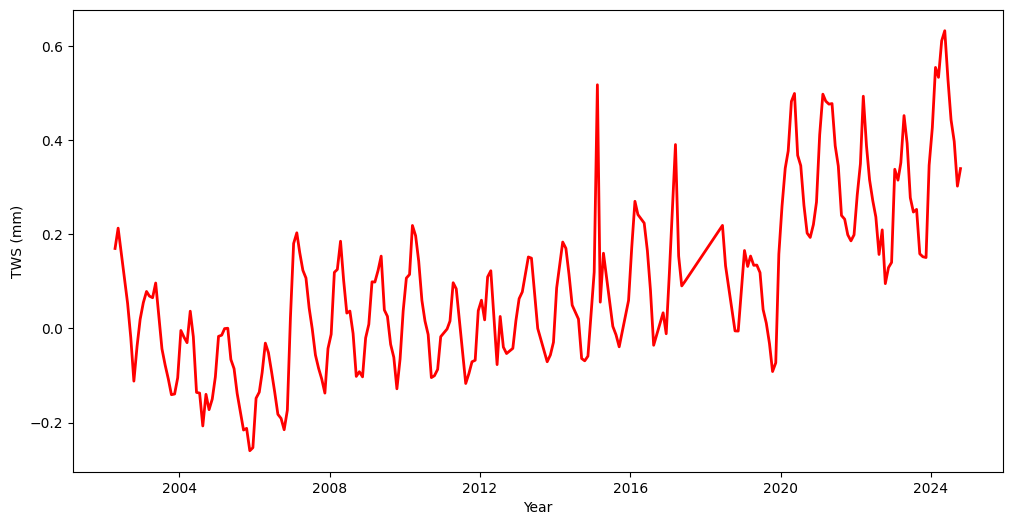

In [72]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
plt.xlabel("Year")
plt.ylabel("TWS (mm)")
# plt.title("Time Series Plot")
plt.show()


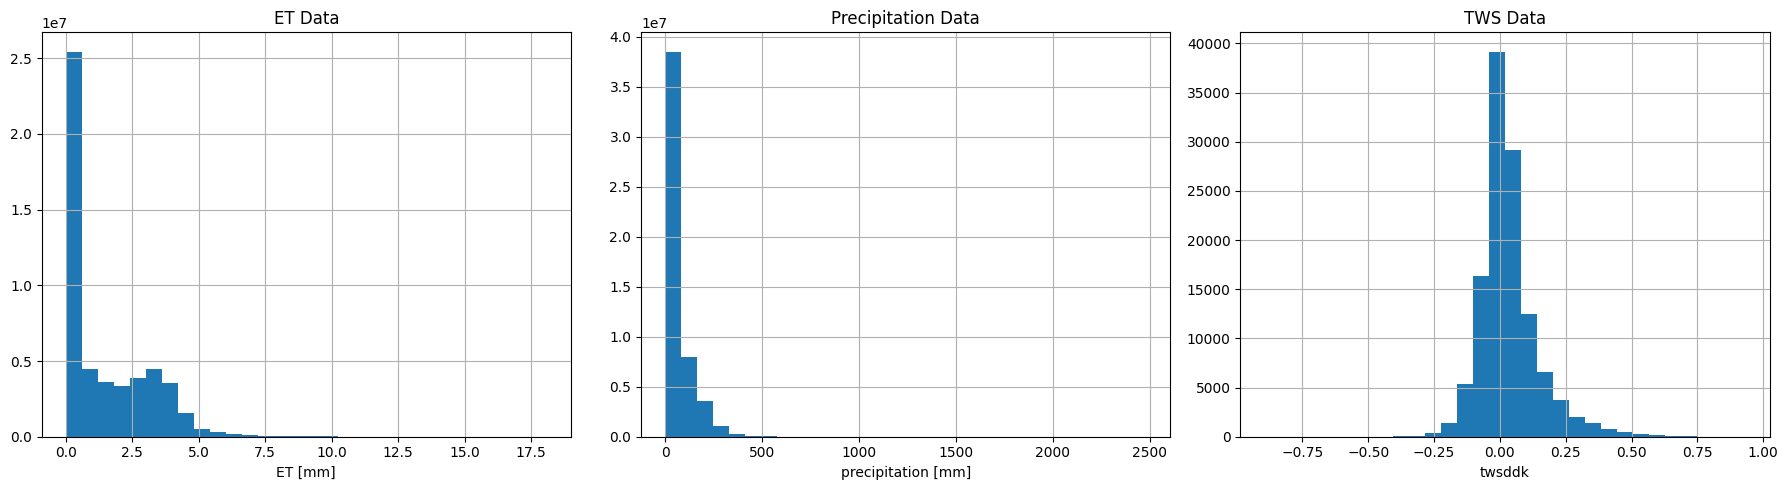

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

et_data.plot.hist(ax=axes[0], bins=30)
axes[0].grid(True)
axes[0].set_title('ET Data')

precipitation_data.plot.hist(ax=axes[1], bins=30)
axes[1].grid(True)
axes[1].set_title('Precipitation Data')

tws_data.plot.hist(ax=axes[2], bins=30)
axes[2].grid(True)
axes[2].set_title('TWS Data')

plt.tight_layout()
plt.show()

In [167]:
(et_data.values[et_data.values > 10])

array([10.01      , 10.17406897, 10.26413793, ..., 10.086     ,
       10.047     , 10.003     ])

(array([ 47099., 124863., 177742., 138650., 129974., 178433., 225326.,
        257718., 321833., 377087., 425062., 472135., 543088., 576599.,
        627485., 649320., 689003., 687298., 677096., 646096., 621216.,
        598459., 585321., 569143., 564803., 557183., 565463., 579584.,
        608524., 621899., 610651., 576630., 533198., 481198., 443300.,
        401966., 367427., 331536., 303929., 268729., 238560., 201440.,
        174874., 148043., 127907., 108876.,  96390.,  84592.,  77505.,
         71011.,  67141.,  62540.,  59985.,  56754.,  55725.,  52993.,
         52739.,  50891.,  50812.,  49653.,  49363.,  48374.,  48120.,
         47185.,  47233.,  46297.,  45953.,  44950.,  45269.,  43950.,
         44419.,  43806.,  43623.,  42582.,  42546.,  41556.,  41445.,
         41340.,  41108.,  40753.,  40478.,  40022.,  39932.,  39413.,
         38980.,  38242.,  38678.,  37741.,  37777.,  37423.,  37640.,
         37012.,  36935.,  36307.,  36349.,  35868.,  36007.,  35202.,
      

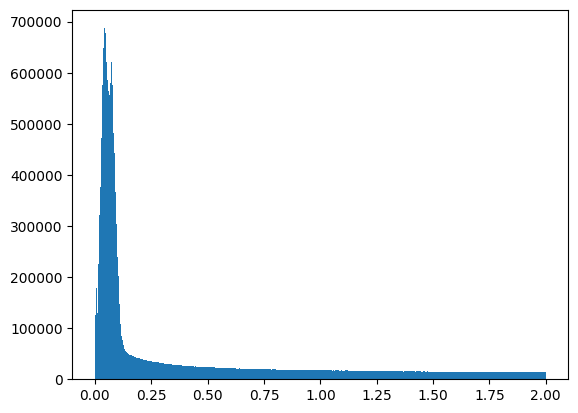

In [176]:
plt.hist(et_data.values[et_data.values < 2], bins=800)

#### Regriding datasets

In [18]:
# Interpolate to match the TWS grid
precip_resampled = precipitation_data.interp(y=tws_data.lat, x=tws_data.lon, method='nearest')
et_resampled = et_data.interp(lat=tws_data.lat, lon=tws_data.lon, method='nearest')

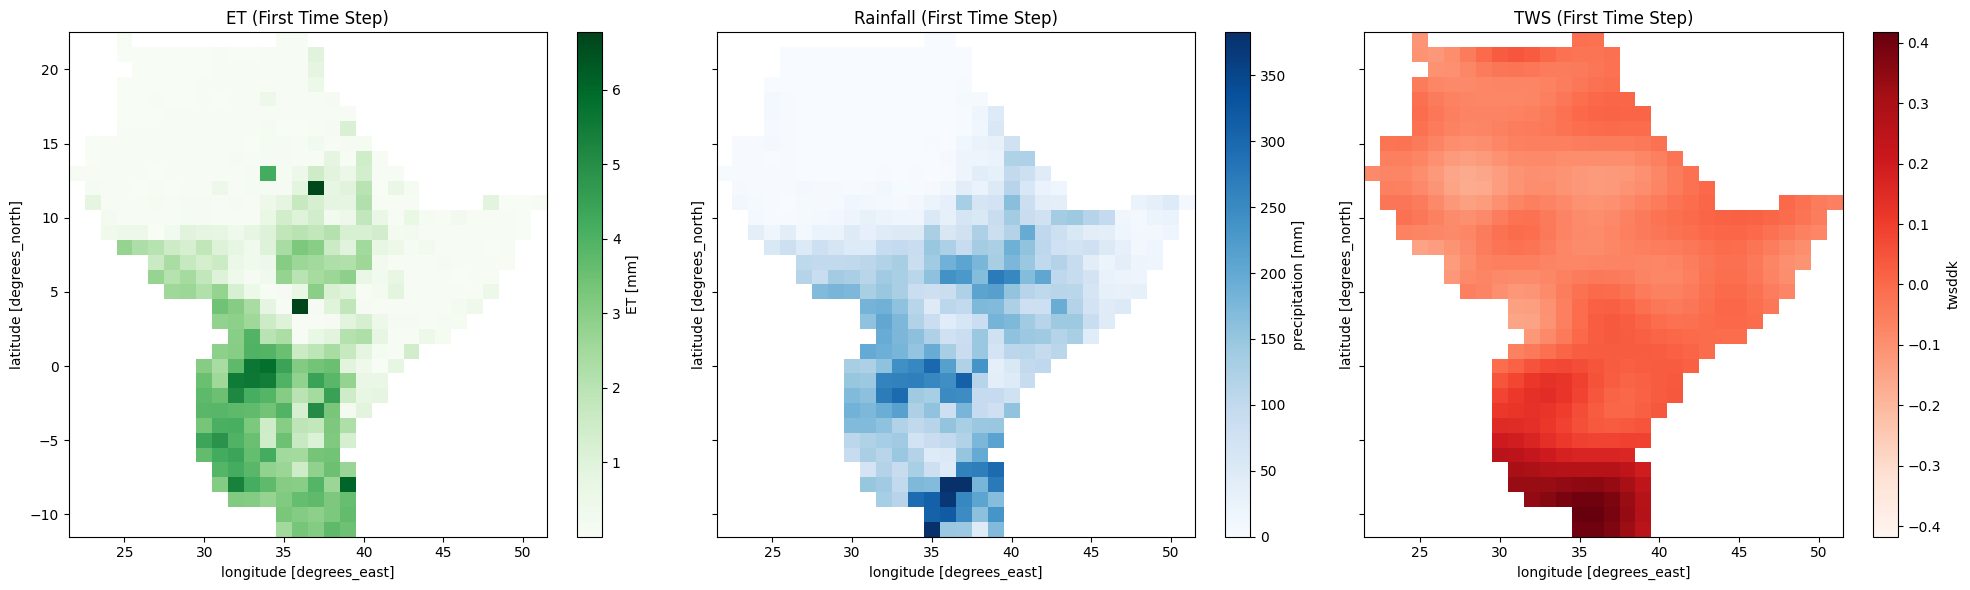

In [19]:
# Plot the regrided datasets

et2 = et_resampled.isel(time=0)
precip2 = precip_resampled.isel(time=0)
tws2 = tws_data.isel(time=0)

# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
et2.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
precip2.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
tws2.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

plt.tight_layout()
plt.show()

### Anomalies Calculation

#### Evapotranspitation

In [20]:
# Calculate monthly climatology (mean for each month over the years)
et_climatology = et_data.groupby("time.month").mean("time")

# Calculate anomalies
et_anomalies = et_data.groupby("time.month") - et_climatology

# Calculate monthly standard deviation over the years
et_std = et_data.groupby("time.month").std("time")

# Calculate standardized anomalies
et_standardized_anomalies = et_anomalies / et_std


In [21]:
et_standardized_anomalies

<xarray.DataArray 'ET' (time: 252, lat: 697, lon: 592, month: 12)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float32 23.1 23.05 23.0 22.95 ... -11.55 -11.6 -11.65 -11.7
  * lon      (lon) float32 21.85 21.9 21.95 22.0 22.05 ... 51.25 51.3 51.35 51.4
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-12-01
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

#### Precipitation

In [22]:
# Calculate monthly climatology (mean for each month over the years)
precipitation_clim = precipitation_data.groupby("time.month").mean("time")

# Calculate anomalies
precipitation_anomalies = precipitation_data.groupby("time.month") - precipitation_clim

# Calculate the standard deviation for each month over the years
precipitation_std = precipitation_data.groupby("time.month").std("time")

# Calculate standardized anomalies
pre_standardized_anomalies = precipitation_anomalies / precipitation_std


In [23]:
pre_standardized_anomalies

<xarray.DataArray 'precipitation' (time: 250, y: 698, x: 591, month: 12)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    band     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * y        (y) float64 23.12 23.07 23.02 22.97 ... -11.58 -11.63 -11.68 -11.73
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

#### TWS

In [24]:
# Calculate monthly climatology (mean for each month over the years)
tws_clim = tws_data.groupby("time.month").mean("time")

# Calculate anomalies
tws_anomalies = tws_data.groupby("time.month") - tws_clim

# Calculate the standard deviation for each month over the years
tws_std = tws_data.groupby("time.month").std("time")

# Calculate standardized anomalies
tws_standardized_anomalies = tws_anomalies / tws_std


In [25]:
tws_standardized_anomalies

<xarray.DataArray 'twsddk' (lat: 34, lon: 30, time: 237, month: 12)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
  * lat      (lat) float64 -11.0 -10.0 -9.0 -8.0 -7.0 ... 19.0 20.0 21.0 22.0
  * lon      (lon) float64 22.0 23.0 24.0 25.0 26.0 ... 47.0 48.0 49.0 50.0 51.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Standardization with regridded data

In [26]:
# ET
et_climatology = et_resampled.groupby("time.month").mean("time")

et_anomalies = et_resampled.groupby("time.month") - et_climatology

et_std = et_resampled.groupby("time.month").std("time")

# et_std = et_std.where(~np.isnan(et_std), 1e-6)  # Replace NaNs with small value

# et_st_anomalies = et_anomalies / et_std

et_st_anomalies = et_anomalies / et_std



In [27]:
print("New Median Standard Deviation:", np.nanmedian(et_std.values))


New Median Standard Deviation: 0.31112402348595014


In [28]:
# Preciptation
precipitation_clim = precip_resampled.groupby("time.month").mean("time")

precipitation_anomalies = precip_resampled.groupby("time.month") - precipitation_clim

precipitation_std = precip_resampled.groupby("time.month").std("time")

pre_st_anomalies = precipitation_anomalies / precipitation_std


In [29]:
# TWS
tws_clim = tws_data.groupby("time.month").mean("time")

tws_anomalies = tws_data.groupby("time.month") - tws_clim

tws_std = tws_data.groupby("time.month").std("time")

tws_st_anomalies = tws_anomalies / tws_std


In [30]:
import numpy as np

print("Minimum standard deviation:", et_std.min().values)
print("Median standard deviation:", np.median(et_std.values))


Minimum standard deviation: 0.0002422645547063659
Median standard deviation: nan


In [31]:
print("Max original ET:", et_resampled.max().values)
print("Max anomalies:", et_anomalies.max().values)
print("Max standardized anomalies:", et_st_anomalies.max().values)


Max original ET: 9.422366666666669
Max anomalies: 3.662789008548721
Max standardized anomalies: 7213.497926875151


In [33]:
print("Number of NaNs in et_std:", np.isnan(tws_data.values).sum())

Number of NaNs in et_std: 121581


## Marginal Distribution

#### Clean data and stack

In [34]:
# Remove NaNs from the standardised anomalies
et_clean = et_st_anomalies.stack(dims=['lon', 'lat', 'time', 'month'])

et_clean = et_clean[~np.isnan(et_clean)]
et_clean

<xarray.DataArray 'ET' (dims: 1527084)>
array([ 1.4119531 ,  1.48109937,  2.29820037, ..., -0.63087251,
       -0.42908807, -0.51322579])
Coordinates:
  * dims     (dims) object MultiIndex
  * lon      (dims) float64 22.0 22.0 22.0 22.0 22.0 ... 51.0 51.0 51.0 51.0
  * lat      (dims) float64 13.0 13.0 13.0 13.0 13.0 ... 11.0 11.0 11.0 11.0
  * time     (dims) datetime64[ns] 2004-01-01 2004-01-01 ... 2024-12-01
  * month    (dims) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [35]:
et_clean.min()

<xarray.DataArray 'ET' ()>
array(-3091.15721014)

In [36]:
# Stack all dimensions
precip_clean = pre_st_anomalies.stack(dims=['lon', 'lat', 'time', 'month'])

precip_clean = precip_clean[~np.isnan(precip_clean)]
precip_clean

<xarray.DataArray 'precipitation' (dims: 1512000)>
array([-0.6829945 , -0.8248405 , -1.0487558 , ..., -0.17979637,
       -0.31722966, -0.44643858], dtype=float32)
Coordinates:
    band     (dims) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    y        (dims) float64 13.0 13.0 13.0 13.0 13.0 ... 11.0 11.0 11.0 11.0
    x        (dims) float64 22.0 22.0 22.0 22.0 22.0 ... 51.0 51.0 51.0 51.0
  * dims     (dims) object MultiIndex
  * lon      (dims) float64 22.0 22.0 22.0 22.0 22.0 ... 51.0 51.0 51.0 51.0
  * lat      (dims) float64 13.0 13.0 13.0 13.0 13.0 ... 11.0 11.0 11.0 11.0
  * time     (dims) datetime64[ns] 2004-01-01 2004-01-01 ... 2024-10-01
  * month    (dims) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [37]:
precip_clean.min()

<xarray.DataArray 'precipitation' ()>
array(-5.13687944)

In [38]:
# Stack all dimensions
tws_clean = tws_st_anomalies.stack(dims=['lon', 'lat', 'time', 'month'])

tws_clean = tws_clean[~np.isnan(tws_clean)]
tws_clean

<xarray.DataArray 'twsddk' (dims: 1441908)>
array([-0.99707516, -0.51881495, -0.76740908, ...,  0.83226953,
        0.45289833,  0.52951518])
Coordinates:
  * dims     (dims) object MultiIndex
  * lon      (dims) float64 22.0 22.0 22.0 22.0 22.0 ... 51.0 51.0 51.0 51.0
  * lat      (dims) float64 13.0 13.0 13.0 13.0 13.0 ... 11.0 11.0 11.0 11.0
  * time     (dims) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
  * month    (dims) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [39]:
tws_clean.min()

<xarray.DataArray 'twsddk' ()>
array(-22.49978509)

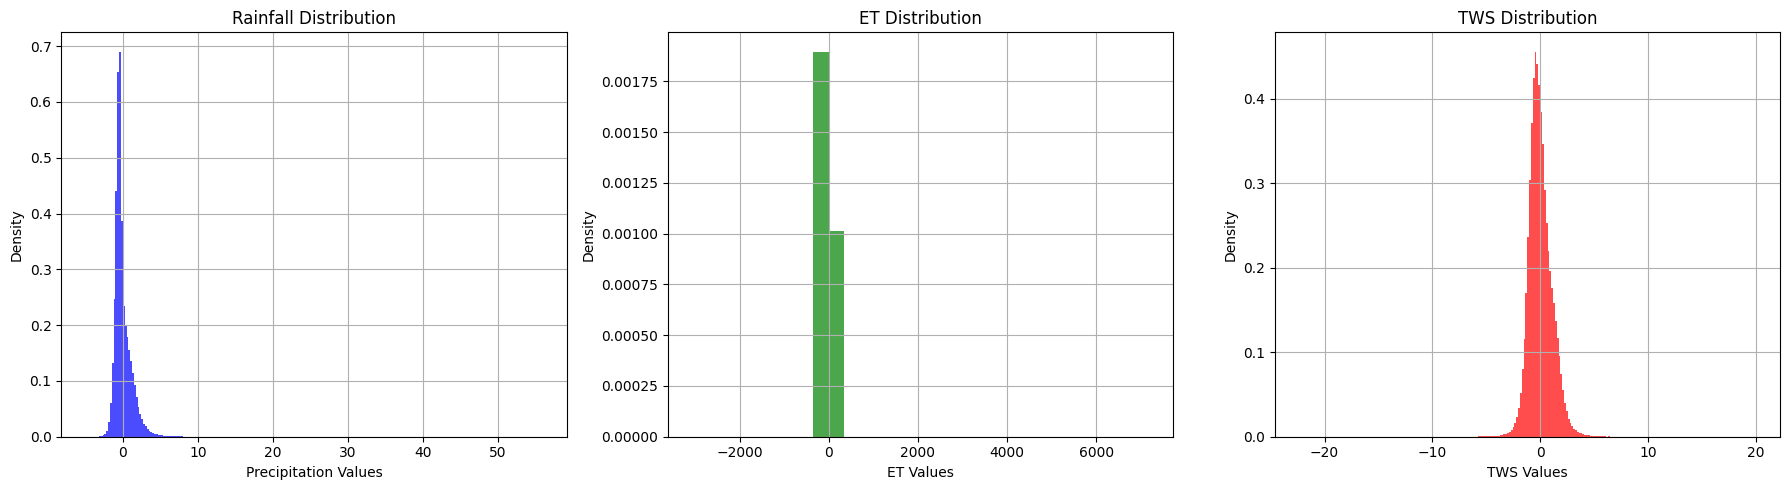

In [109]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Precipitation Histogram
axes[0].hist(precip_clean, bins=250, density=True, alpha=0.7, color='blue')
axes[0].set_title("Rainfall Distribution")
axes[0].set_xlabel("Precipitation Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot ET Histogram
axes[1].hist(et_clean, bins=30, density=True, alpha=0.7, color='green')
axes[1].set_title("ET Distribution")
axes[1].set_xlabel("ET Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_clean, bins=250, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [41]:
# Generate the ECDF for each variable which is needed to fit the copula model

import statsmodels.api as sm

# ECDF for rainfall
ecdf_rainfall = sm.distributions.ECDF(precip_clean)


In [43]:
ecdf_rainfall.x

array([      -inf, -5.1368794, -5.1368794, ..., 49.07216  , 49.876118 ,
       56.121338 ], dtype=float32)

In [44]:
# Compute ECDF for ET
ecdf_et = ECDF(et_clean)

# Compute ECDF for Precipitation
ecdf_precip = ECDF(precip_clean)

# Compute ECDF for TWS
ecdf_twsa = ECDF(tws_clean)


In [45]:
ecdf_precip.x

array([      -inf, -5.1368794, -5.1368794, ..., 49.07216  , 49.876118 ,
       56.121338 ], dtype=float32)

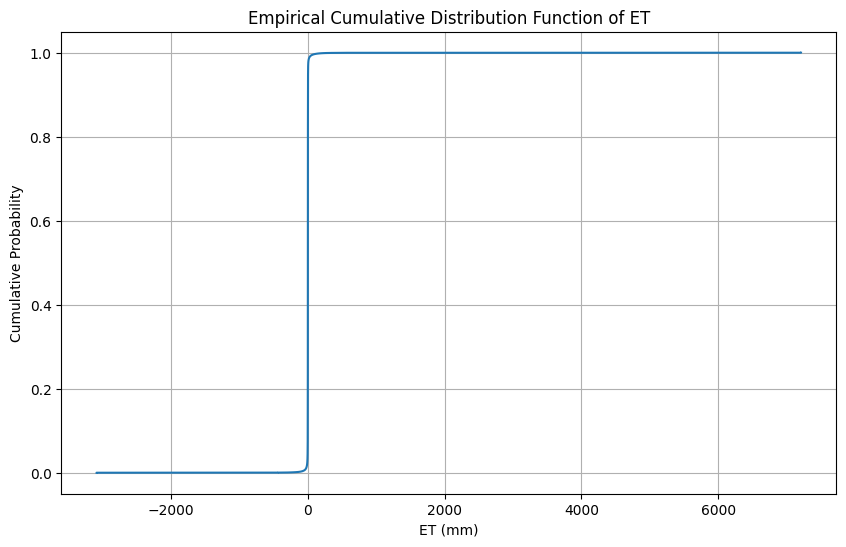

In [105]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_et.x, ecdf_et.y, where='post')
plt.xlabel('ET (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of ET')
plt.grid(True)
plt.show()

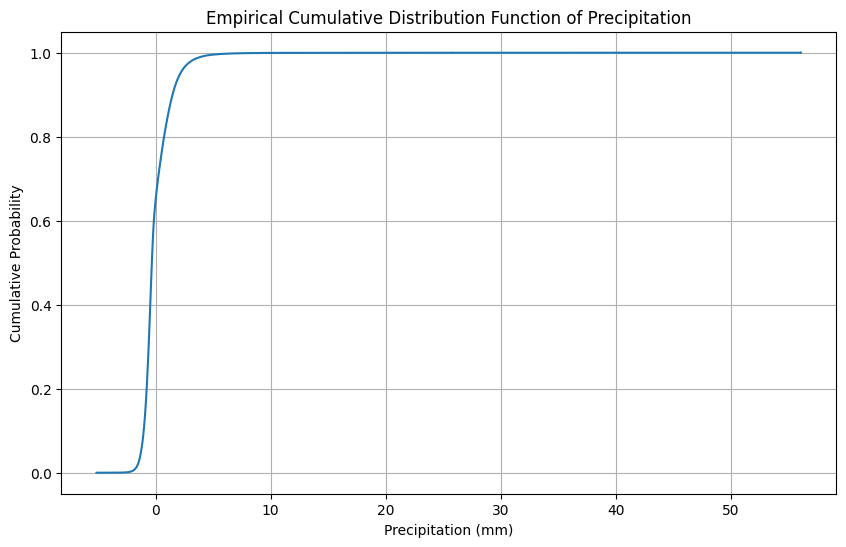

In [106]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_precip.x, ecdf_precip.y, where='post')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of Precipitation')
plt.grid(True)
plt.show()


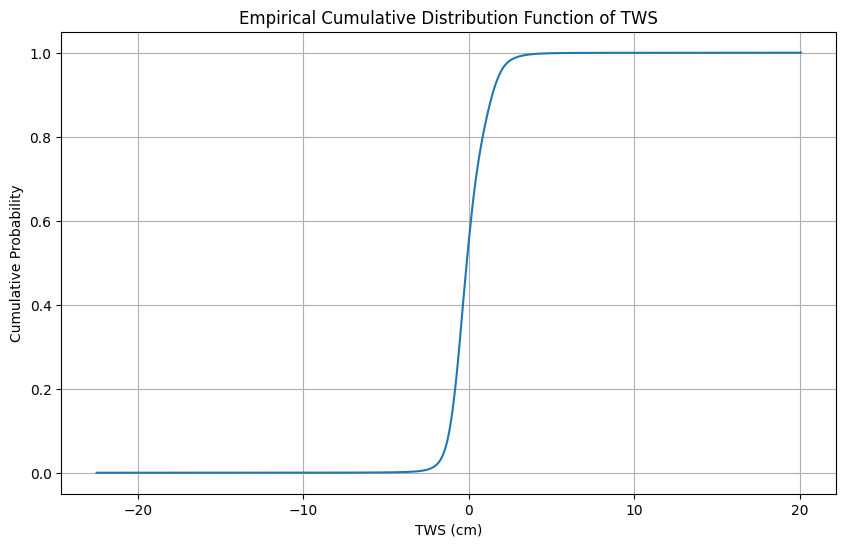

In [107]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_twsa.x, ecdf_twsa.y, where='post')
plt.xlabel('TWS (cm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of TWS')
plt.grid(True)
plt.show()

#### Transform to uniform margin

In [49]:
# Transform TWSA data
uniform_twsa = ecdf_twsa(tws_clean)

# Transform Precip data
uniform_precip = ecdf_precip(precip_clean)

# Transform ET data
uniform_et = ecdf_et(et_clean)


In [50]:
# Select subset of the data
uniform_data = np.column_stack([uniform_et[:50000], uniform_precip[:50000], uniform_twsa[:50000]])

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from copulae import GaussianCopula, StudentCopula, ClaytonCopula, GumbelCopula, FrankCopula

# # Function to plot scatter plots of real vs. simulated data
# def plot_real_vs_simulated(real_data, simulated_data, copula_name):
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
#     # Real data
#     sns.scatterplot(x=real_data[:, 0], y=real_data[:, 1], alpha=0.5, ax=axes[0])
#     axes[0].set_title(f"Real Data: {copula_name}")

#     # Simulated data
#     sns.scatterplot(x=simulated_data[:, 0], y=simulated_data[:, 1], alpha=0.5, ax=axes[1])
#     axes[1].set_title(f"Simulated Data: {copula_name}")

#     plt.show()

# # Fit different copulas
# copulas = {
#     "Gaussian": GaussianCopula(dim=3),
#     "t": StudentCopula(dim=3, df=5),
#     "Clayton": ClaytonCopula(dim=3),
#     "Gumbel": GumbelCopula(dim=3),
#     "Frank": FrankCopula(dim=3)
# }

# # Plot original pairwise scatter plots
# sns.pairplot(pd.DataFrame(uniform_data, columns=["ET", "Precip", "TWSA"]))
# plt.suptitle("Pairwise Scatter Plot of Real Data", y=1.02)
# plt.show()

# # Fit copulas and generate simulated data
# for name, copula in copulas.items():
#     copula.fit(uniform_data)  # Fit copula
#     simulated_data = copula.random(1000)  # Simulate same number of samples
#     plot_real_vs_simulated(uniform_data, simulated_data, name)


#### Fit to Copula

##### Archimidean Copulas

In [47]:
# Using Copulae Module
from copulae import GaussianCopula, ClaytonCopula, FrankCopula, GumbelCopula, StudentCopula

In [98]:
gumbel_copula = GumbelCopula(dim=3)  # You can also try ClaytonCopula() or GumbelCopula()
gumbel_copula.fit(uniform_data)

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


In [99]:
gumbel_copula.summary()

Gumbel Copula Summary
================================================================================
Gumbel Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.0

In [56]:
# Simulate new uniform marginals from the copula
simulated_data_gumbel = copula.random(1000)

In [57]:
simulated_data_gumbel

array([[0.65390687, 0.45993297, 0.97459401],
       [0.85207955, 0.83664666, 0.06711712],
       [0.15092186, 0.83083045, 0.35585147],
       ...,
       [0.62579531, 0.10454394, 0.7266643 ],
       [0.3413306 , 0.61187804, 0.10739395],
       [0.59704403, 0.06090679, 0.10306397]])

In [63]:
# Transform back to the original scales using the inverse ECDFs
gumbel_simulated_et = np.quantile(et_clean, simulated_data_gumbel[:, 0])
gumbel_simulated_precip = np.quantile(precip_clean, simulated_data_gumbel[:, 1])
gumbel_simulated_twsa = np.quantile(tws_clean, simulated_data_gumbel[:, 2])

##### N

In [73]:
# Clayton Copula
clayton_copula = ClaytonCopula(dim=3)
clayton_copula.fit(uniform_data, x0=[1.0])

In [74]:
clayton_copula.summary()

Clayton Copula Summary
================================================================================
Clayton Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.525878905361823e-06

In [92]:
simulated_data_clayton = clayton_copula.random(50000)

In [96]:
# Transform back to the original scales using the inverse ECDFs
clayton_simulated_et = np.quantile(et_clean, simulated_data_clayton[:, 0])
clayton_simulated_precip = np.quantile(precip_clean, simulated_data_clayton[:, 1])
clayton_simulated_twsa = np.quantile(tws_clean, simulated_data_clayton[:, 2])

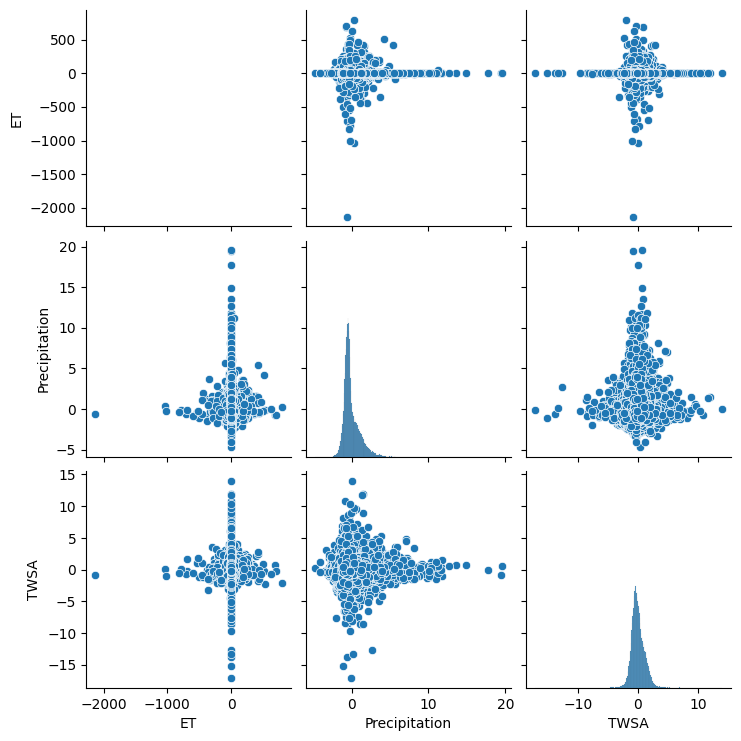

In [97]:
# Plot the simulated data
sns.pairplot(pd.DataFrame({
    'ET': clayton_simulated_et,
    'Precipitation': clayton_simulated_precip,
    'TWSA': clayton_simulated_twsa
}))
plt.show()

In [95]:
uniform_data

array([[0.88918357, 0.25201984, 0.14563759],
       [0.89538493, 0.1767328 , 0.32608599],
       [0.93975773, 0.09595569, 0.22228395],
       ...,
       [0.54127671, 0.41546495, 0.77958025],
       [0.54091523, 0.48090807, 0.76930706],
       [0.54303234, 0.41732209, 0.73992932]])

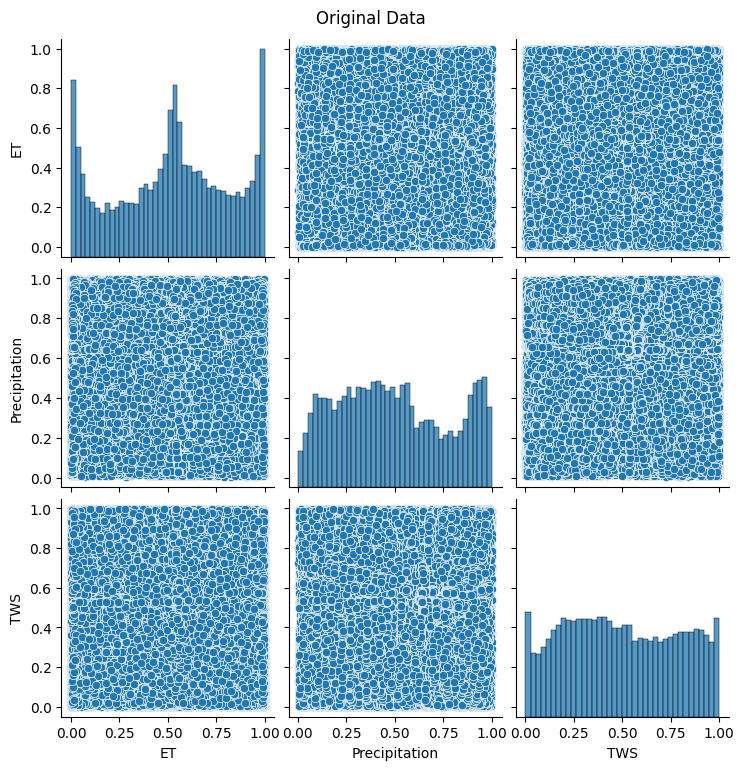

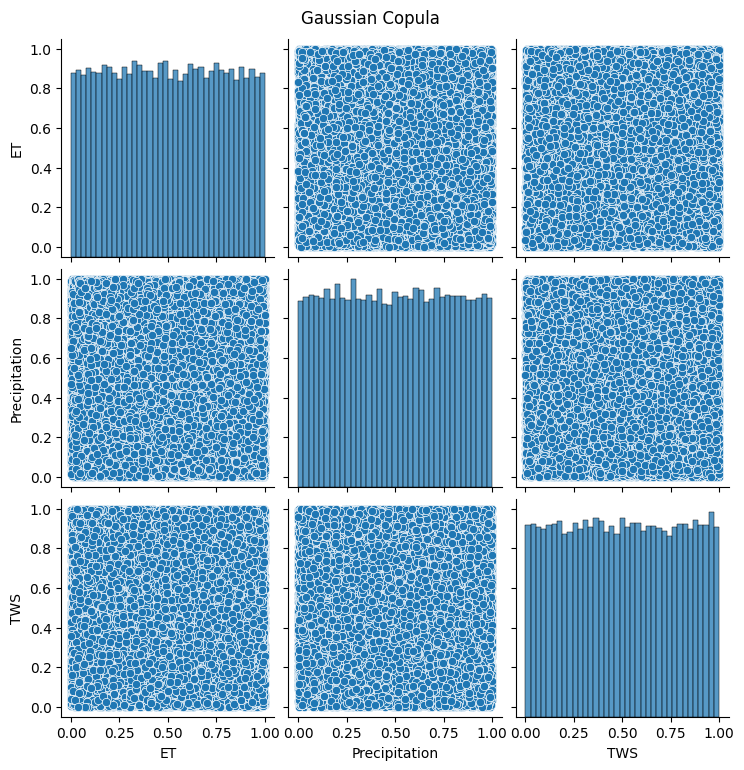

In [93]:
# Original data
sns.pairplot(pd.DataFrame(uniform_data, columns=['ET', 'Precipitation', 'TWS']))
plt.suptitle("Original Data", y=1.02)
plt.show()

# Synthetic data from Gaussian Copula
sns.pairplot(pd.DataFrame(simulated_data_clayton, columns=['ET', 'Precipitation', 'TWS']))
plt.suptitle("Gaussian Copula", y=1.02)
plt.show()

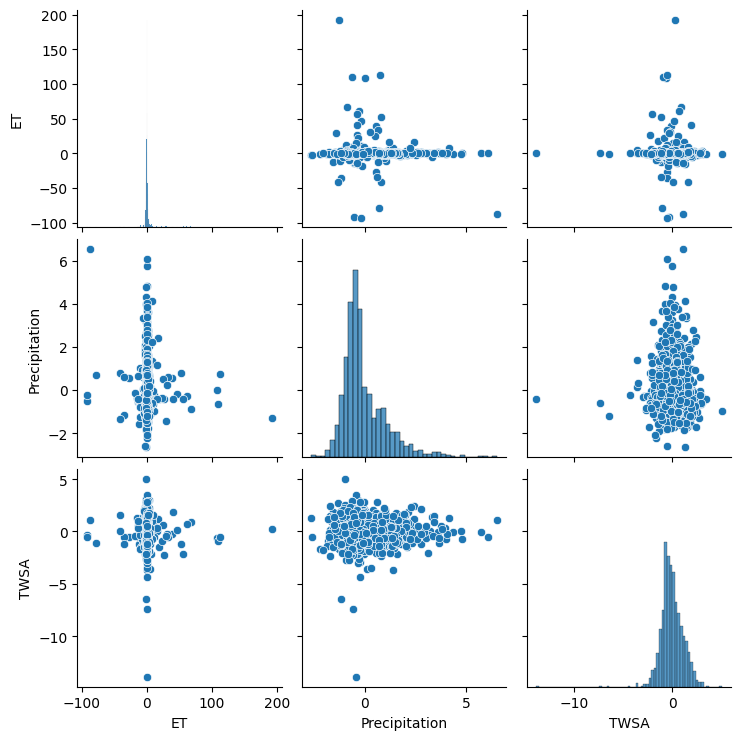

In [65]:
# Plot the simulated data
sns.pairplot(pd.DataFrame({
    'ET': gumbel_simulated_et,
    'Precipitation': gumbel_simulated_precip,
    'TWSA': gumbel_simulated_twsa
}))
plt.show()

In [70]:
# Define thresholds
a = np.quantile(et_clean, 0.9)  # 90th percentile for ET
b = np.quantile(precip_clean, 0.9)  # 90th percentile for Precipitation
c = np.quantile(tws_clean, 0.9)  # 90th percentile for TWSA

# Transform thresholds to uniform scale
u_a = ecdf_et(a)
u_b = ecdf_precip(b)
u_c = ecdf_twsa(c)

# Compute joint probability using the copula
joint_probability = arc_coupula_g.cdf([u_a, u_b, u_c])
print(f"Joint probability: {joint_probability}")

Joint probability: 0.7282660230484711


##### Elliptical Copulas

In [59]:
# Gaussian Copula
guassian_copula = GaussianCopula(dim=3)
guassian_copula.fit(uniform_data)

In [60]:
guassian_copula.summary()

Gaussian Copula Summary
================================================================================
Gaussian Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
 1.000000 -0.011341 -0.017454
-0.011341  1.000000  0.002006
-0.017454  0.002006  1.000000

In [61]:
# Simulate new uniform marginals from the copula
simulated_data_gaussian = guassian_copula.random(1000)

In [62]:
simulated_data_gaussian

array([[0.92008814, 0.39050932, 0.15669442],
       [0.6672816 , 0.29757212, 0.27160315],
       [0.71552841, 0.89386766, 0.60690485],
       ...,
       [0.61074194, 0.41954842, 0.39161827],
       [0.40247358, 0.77553851, 0.64380238],
       [0.41430196, 0.54544064, 0.94584642]])

In [64]:
# Transform back to the original scales using the inverse ECDFs
gaussian_simulated_et = np.quantile(et_clean, simulated_data_gaussian[:, 0])
gaussian_simulated_precip = np.quantile(precip_clean, simulated_data_gaussian[:, 1])
gaussian_simulated_twsa = np.quantile(tws_clean, simulated_data_gaussian[:, 2])

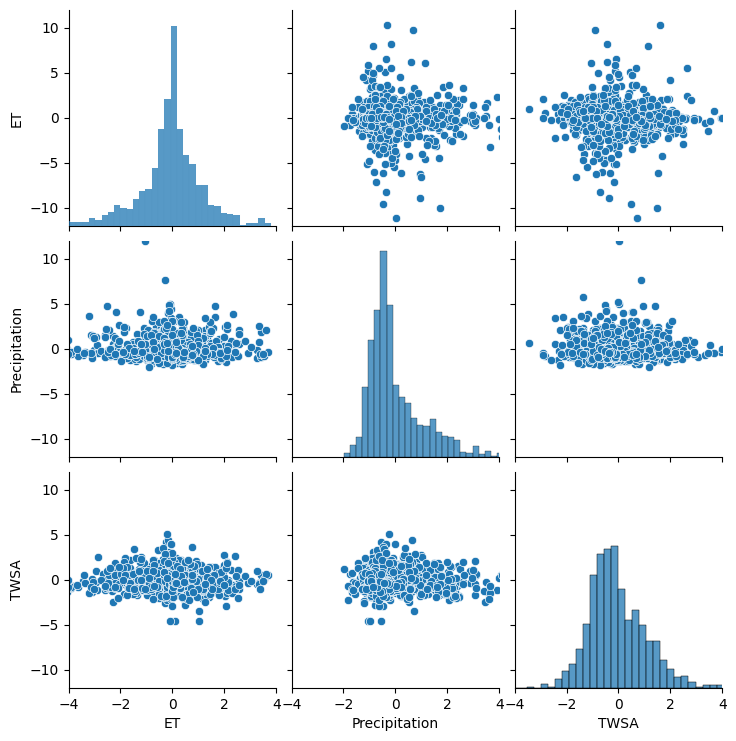

In [68]:
# Plot the simulated data
g = sns.pairplot(pd.DataFrame({
    'ET': gaussian_simulated_et,
    'Precipitation': gaussian_simulated_precip,
    'TWSA': gaussian_simulated_twsa
}))
# Adjust the y-axis limits for ET plots
for ax in g.axes[:, 0]:  # First column (ET on y-axis)
    ax.set_ylim(-12, 12)  # Set y-axis limits for ET

for ax in g.axes[0, :]:  # First row (ET on x-axis)
    ax.set_xlim(-4, 4)  # Set x-axis limits for ET
    
plt.show()

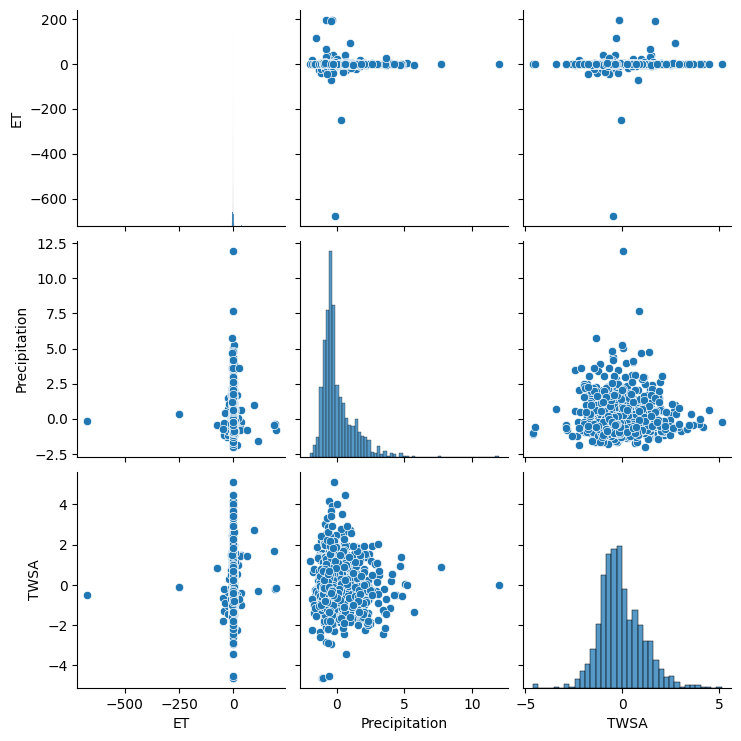

In [67]:
# Plot the simulated data
g = sns.pairplot(pd.DataFrame({
    'ET': gaussian_simulated_et,
    'Precipitation': gaussian_simulated_precip,
    'TWSA': gaussian_simulated_twsa
}))

plt.show()

In [79]:
# Student t copula
student_copula = StudentCopula(dim=3)
student_copula.fit(uniform_data)


In [80]:
# Simulate new uniform marginals from the copula
simulated_uniform_student = student_copula.random(1000)

In [81]:
simulated_uniform_student

array([[0.48255967, 0.5050711 , 0.05704094],
       [0.65832975, 0.12165576, 0.93724722],
       [0.91098552, 0.58208632, 0.24948191],
       ...,
       [0.17210097, 0.80259286, 0.01032422],
       [0.55554604, 0.43606953, 0.63611862],
       [0.6240138 , 0.89964088, 0.14550124]])

In [83]:
# Transform back to the original scales using the inverse ECDFs
student_simulated_et = np.quantile(et_clean, simulated_uniform_student[:, 0])
student_simulated_precip = np.quantile(precip_clean, simulated_uniform_student[:, 1])
student_simulated_twsa = np.quantile(tws_clean, simulated_uniform_student[:, 2])

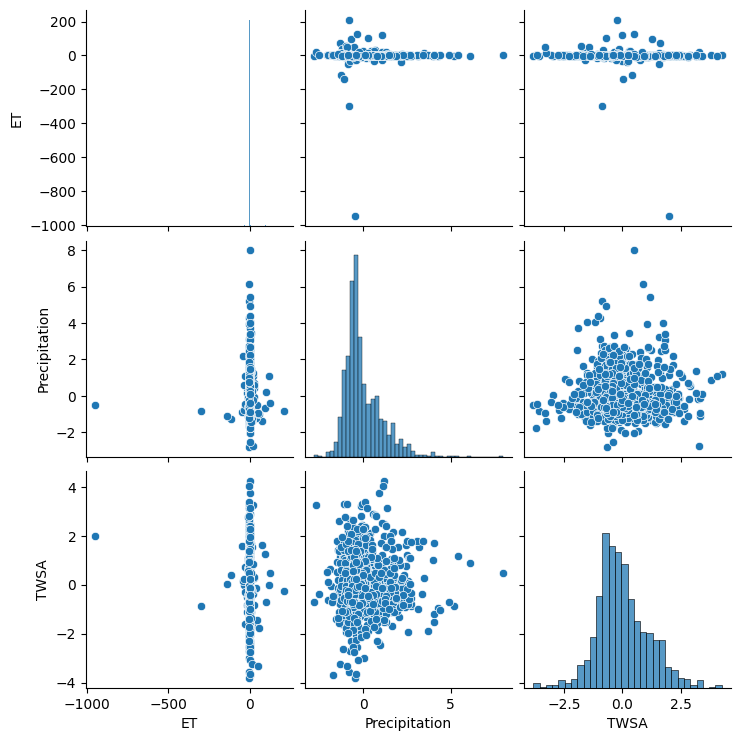

In [84]:
# Create the pairplot
g = sns.pairplot(pd.DataFrame({
    'ET': student_simulated_et,
    'Precipitation': student_simulated_precip,
    'TWSA': student_simulated_twsa
}))

# # Adjust the y-axis limits for ET plots
# for ax in g.axes[:, 0]:  # First column (ET on y-axis)
#     ax.set_ylim(-12, 12)  # Set y-axis limits for ET

# for ax in g.axes[0, :]:  # First row (ET on x-axis)
#     ax.set_xlim(-4, 4)  # Set x-axis limits for ET

plt.show()

### Goodness of fit 

In [103]:
copulas = {
    'Gaussian': guassian_copula,
    't-Copula': student_copula,
    'Gumbel': gumbel_copula,
    'Clayton': clayton_copula,
    # 'Frank': FrankCopula()
}

In [112]:
from scipy.stats import kstest

def goodness_of_fit(copula, data):
    
    theoretical_cdf = copula.random(len(data))
    # Perform KS test
    ks_stat, p_value = kstest(data.flatten(), theoretical_cdf.flatten())
    return ks_stat, p_value

# Evaluate each copula
results = {}
for name, copula in copulas.items():
    ks_stat, p_value = goodness_of_fit(copula, uniform_data)
    results[name] = {'KS Statistic': ks_stat, 'p-value': p_value}

# Print results
for name, result in results.items():
    print(f"{name}: KS Statistic = {result['KS Statistic']}, p-value = {result['p-value']}")

Gaussian: KS Statistic = 0.02518666666666669, p-value = 9.17574228109953e-42
t-Copula: KS Statistic = 0.02535333333333334, p-value = 2.5924336782431715e-42
Gumbel: KS Statistic = 0.022639999999999993, p-value = 7.94046964904015e-34
Clayton: KS Statistic = 0.022706666666666653, p-value = 5.044804912252901e-34


In [165]:
t = []
for name, copula in copulas.items():
        if name == 't-Copula':
            param_size = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel':
            param_size = np.array(copula.params).size
        elif name == 'Gaussian':
            param_size = copula.params.size
        t.append(param_size)
        
t

[3, 3, 1, 1]

#####  Test the copulas

In [166]:
# Compute log-likelihood, AIC, and BIC for each copula

results = []
for name, copula in copulas.items():
        log_likelihood = copula.log_lik(uniform_data)
        if name == 't-Copula':
            param_size = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel':
            param_size = np.array(copula.params).size
            print(param_size)
        elif name == 'Gaussian':
            param_size = copula.params.size
        aic = -2 * log_likelihood + 2 * param_size
        bic = -2 * log_likelihood + np.log(uniform_data.shape[0]) * param_size
        results.append({
            "Copula": name,
            "Log-Likelihood": log_likelihood,
            "AIC": aic,
            "BIC": bic,
            "Size": param_size
        })


# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

1
1
     Copula  Log-Likelihood        AIC        BIC  Size
0  Gaussian       10.905843 -15.811687  10.647648     3
1  t-Copula       47.732093 -89.464186 -63.004851     3
2    Gumbel        0.000000   2.000000  10.819778     1
3   Clayton       -0.000169   2.000339  10.820117     1


In [115]:
loglik_student = student_copula.log_lik(uniform_data)

In [116]:
loglik_student

47.732092778523466

In [ ]:
loglik_clayton = clayton_copula.log_lik(uniform_data)


In [46]:
marginals = [stats.norm, stats.gamma(2)]  # Define marginal distributions

joint_dist = CopulaDistribution(copula=copula, marginals=marginals)

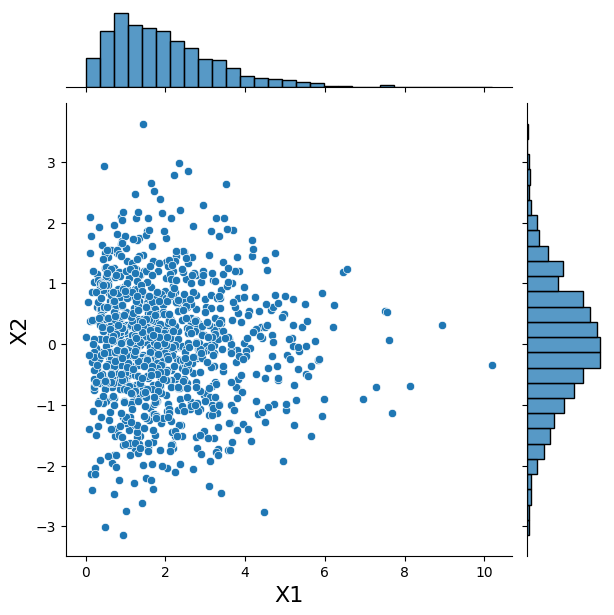

In [105]:
marginals = [stats.gamma(2), stats.norm]
joint_dist = CopulaDistribution(copula=GaussianCopula(), marginals=marginals)
sample = joint_dist.rvs(1000, random_state=20210801)
h = sns.jointplot(x=sample[:, 0], y=sample[:, 1], kind="scatter")
_ = h.set_axis_labels("X1", "X2", fontsize=16)


In [149]:

copula_data = np.column_stack((uniform_et[:1000000], uniform_twsa[:1000000], uniform_precip[:1000000]))

import pandas as pd

# Stack the data into columns and create a DataFrame
data = {
    'et_cdf': et_cdf[:10000],
    'precip_cdf': tws_cdf[:10000],
    'tws_cdf': precip_cdf[:10000]
}

# Create a DataFrame
copula_df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(copula_df.head())



NameError: name 'et_cdf' is not defined

In [134]:

vine_copula = VineCopula('center')

vine_copula.fit(copula_df[:2000])




/home/jovyan/.local/lib/python3.8/site-packages/copulas/bivariate/base.py:163: RuntimeWarning:

Data does not appear to be uniform.



In [108]:
# Stack the data (e.g., TWS and precipitation for a bivariate example)
copula_data = np.column_stack((et_cdf[:10000], tws_cdf[:10000],))

# Fit a Frank copula
copula = Clayton()
copula.fit(copula_data)

copula_samples = copula.sample(1000)
copula_samples_df = pd.DataFrame(copula_samples, columns=['TWS', 'Precipitation'])

# Visualize the fitted copula
scatter_2d(copula_samples_df)
plt.title("Fitted Copula")
plt.show()


NameError: name 'scatter_2d' is not defined

In [114]:
uniform_data.shape

(500000, 3)

In [117]:
# Joint cumulative probability
joint_cdf = copula.cumulative_distribution(copula_data)

# MSDI using standard normal transformation
msdi = norm.ppf(uniform_data)

# Reshape MSDI to match spatial dimensions
msdi_reshaped = np.full(msdi.shape, np.nan)  # Initialize with NaNs
msdi_reshaped.flat[mask] = msdi


NameError: name 'mask' is not defined

In [118]:
msdi_reshaped

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

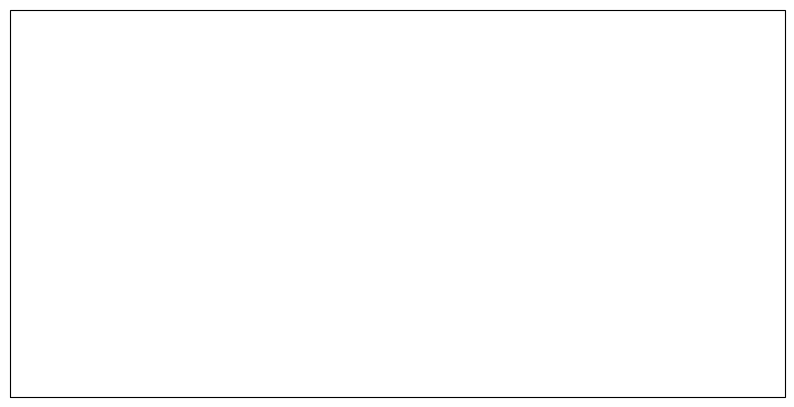

In [119]:
# Example: Plot MSDI for a specific time step
import cartopy.crs as ccrs
time_index = 0  # Change to the desired time index

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(msdi_reshaped[time_index, :, :], levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())
plt.colorbar(label="MSDI")
plt.title("MSDI for Time Step {}".format(time_index))
plt.show()


In [110]:
from copulas.datasets import sample_trivariate_xyz

data = sample_trivariate_xyz()

data.head()

x             y         z
0  9.004177e-05  2.883992e-06  0.638689
1  8.819273e-01  2.911979e-07  1.058121
2  5.003865e-01  4.886504e-04  0.372506
3  1.838544e-12  5.392802e-02  0.687370
4  1.627915e-01  1.634269e-08 -0.881068

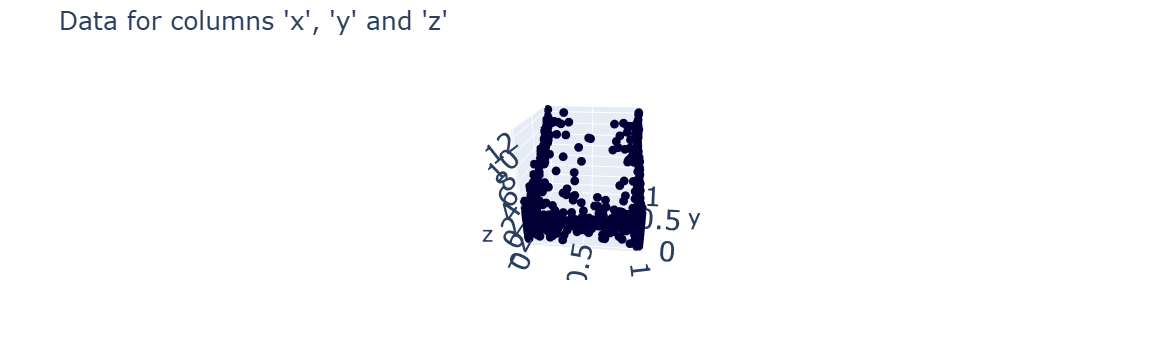

In [111]:
from copulas.visualization import scatter_3d

scatter_3d(data)